In [16]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob




def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass


    return data

def decodeAttributes(string):
    dict={}
    desc=string.split(";")
    for attribute in desc:
        dict[attribute[0]] = float(attribute[1:])
    return dict["p"], dict["a"], dict["l"], dict["s"]

def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    for i in data:
        if round(i.attrs["pointiness"],5) not in pointinessVals: pointinessVals.append(round(i.attrs["pointiness"],5))
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()

    return pointinessVals, spacingVals, lengthVals

def getRuns(spacing,pointiness,length):
    minDist=None
    bestRun=None

    runs=[]
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)*1e9+abs(run.attrs["pointiness"]-pointiness)*100+abs(run.attrs["length"]-length)*1e9
        if dist<0.01:
            runs.append(run)
    
    return runs



data=[]
filePrefix="highResData/"
for name in glob.glob(filePrefix+"*.out"):
    try:
        thisData=loadFile(name+"/table.txt")
    except Exception:
        print(f"Could not load {name}")
        continue
    desc=name[len(filePrefix):-len(".out")]
    pointiness, spacing, length, runNum = decodeAttributes(desc)

    thisData.attrs["pointiness"]=pointiness
    thisData.attrs["spacing"]=spacing
    thisData.attrs["length"]=length
    thisData.attrs["runNum"]=runNum

    data.append(thisData)

pointinessVals, spacingVals, lengthVals = getPossibleVals(data)
print(getPossibleVals(data))



([0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0], [2.8e-07, 3.4e-07, 4e-07], [1.8e-07, 2.3e-07, 3e-07])


In [17]:
def indexOfSame(arr):
    if arr[0]==arr[1] or arr[0]==arr[2]:
        return 0
    if arr[1] == arr[2]:
        return 1

def selectRunIndex(runs):
    Brs = np.array([run.attrs["Br"] for run in runs])
    Hcs = np.array([run.attrs["Hc"] for run in runs])
    Mys = np.array([min(run["hIsland_my"]) for run in runs])

    allAgree=True
    selectedI=None
    for i in [0,1,2]:
        for j in [0,1,2]:
            if i==j: continue

            if(abs(Brs[i]-Brs[j])<0.001 and abs(Hcs[i]-Hcs[j])<1 and abs(Mys[i]-Mys[j]) < 0.001):
                selectedI=i
            else:
                allAgree=False
    
    return allAgree, selectedI



def removeDuplicateRuns(data):
    newData=[]
    numFixes=0
    totalRunCount=0
    unfixable=0
    insufficientTrials=0

    for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length)
                if len(runs)<3:
                    if len(runs)>0:
                        print(pointiness,spacing,length)
                        insufficientTrials+=1
                    continue
                if len(runs)>3:
                    runs=runs[0:3]

                    
                totalRunCount+=1


                Brs = np.array([run.attrs["Br"] for run in runs])
                Hcs = np.array([run.attrs["Hc"] for run in runs])
                Mys = np.array([min(run["hIsland_my"]) for run in runs])

                
                
                allAgree, i = selectRunIndex(runs)

                if not allAgree: numFixes += 1

                if i is None:
                    print(f"Inconsistent data for {pointiness}, {spacing}, {length}")
                    unfixable+=1
                    continue

                newData.append(runs[i])

    print(f"Fixed data for {numFixes}/{totalRunCount} runs. {unfixable} runs unfixable, {insufficientTrials} not enough data")
    return newData

data = removeDuplicateRuns(data)


                



Inconsistent data for 0.0, 3.4e-07, 2.3e-07
Inconsistent data for 0.04, 3.4e-07, 2.3e-07
Inconsistent data for 0.06, 2.8e-07, 1.8e-07
Inconsistent data for 0.06, 4e-07, 3e-07
Inconsistent data for 0.1, 3.4e-07, 2.3e-07
Inconsistent data for 0.16, 2.8e-07, 1.8e-07
Inconsistent data for 0.18, 2.8e-07, 1.8e-07
Inconsistent data for 0.2, 2.8e-07, 1.8e-07
Inconsistent data for 0.2, 4e-07, 3e-07
Inconsistent data for 0.22, 2.8e-07, 1.8e-07
Fixed data for 39/306 runs. 10 runs unfixable, 0 not enough data


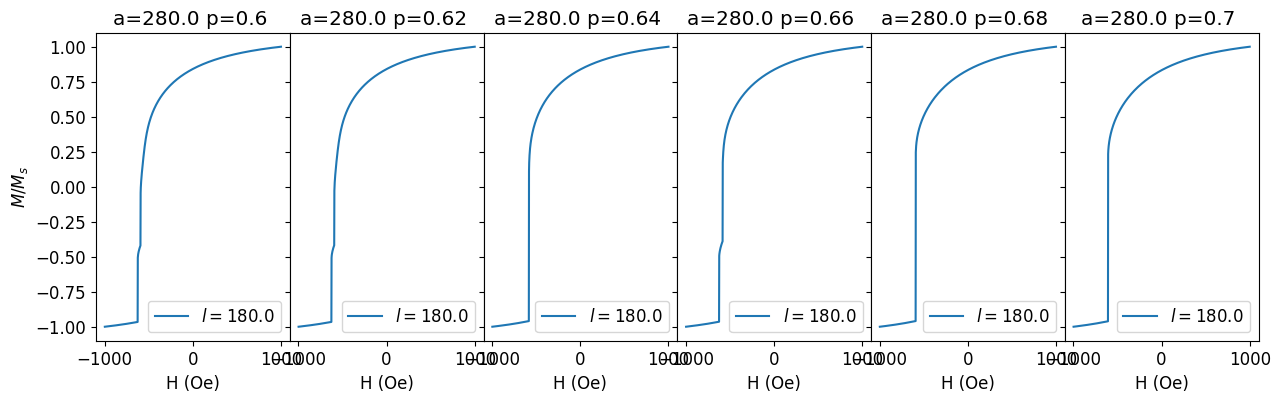

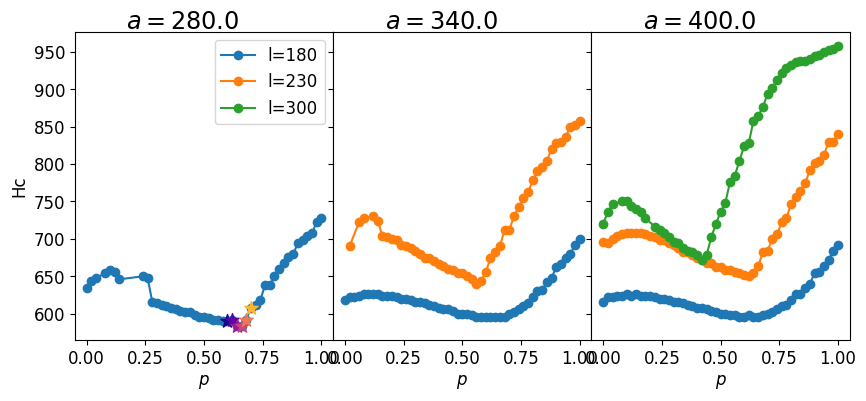

In [292]:
mpl.rcParams.update({'font.size': 12})

def plotAttr(attr,name="",keyPs=[],keyA=0):
    fig,axs=plt.subplots(1,3,sharey=True)
    fig.set_size_inches(10,4)
    plt.subplots_adjust(wspace=0, hspace=0)

    axI=-1
    axs[0].set_ylabel(name)
    for spacing in spacingVals:
        axI+=1
        ax=axs.flatten()[axI]
        for length in lengthVals:
            

            y=[]
            x=[]
            for pointiness in pointinessVals:
                runs = getRuns(spacing,pointiness,length)
                if len(runs)==0:continue
                run=runs[0]
                y.append(attr(run))
                x.append(pointiness)
                if pointiness in keyPs and spacing==keyA:
                    ax.scatter(x[-1],y[-1],marker="*",color=plt.cm.plasma(ps.index(pointiness)/len(ps)),zorder=10,s=100)
            ax.plot(x,y,"o-",label=f"l={round(length*1e9)}")
            ax.set_xlabel("$p$")
        ax.text(0.2,1.01,f"$a={spacing*1e9}$",transform=ax.transAxes,size="x-large")
        if axI==0: ax.legend()
    plt.savefig("test.png",bbox_inches="tight")
    plt.show()

#plotAttr(lambda run:run.attrs["Hc"],"Hc")

#plotAttr(lambda run:run.attrs["Br"],"Mr")

############################################################################
ps=[0.60,0.62,0.64,0.66,0.68,0.70]
#ps=[0.40,0.42,0.44,0.46,0.48]

fig,axs=plt.subplots(1,len(ps),sharey=True,sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)


fig.set_size_inches(15,4)
axs[0].set_ylabel("$M/M_s$")

spacing=280e-9
for pointiness,ax in zip(ps,axs):

    for length in lengthVals:
        runs=getRuns(spacing,pointiness,length)
        if len(runs)==0:continue
        else: run=runs[0]

        ax.plot(run["H"],run["m"],label=f"$l={length*1e9}$")
        ax.set_xlabel("H (Oe)")
        
        ax.set_title(f"a={ run.attrs['spacing']*1e9 } p={round(run.attrs['pointiness'],2)} ")
    ax.legend()
plt.savefig(f"test2.png",bbox_inches="tight")





plotAttr(lambda run:run.attrs["Hc"],"Hc",ps,spacing)
#plotAttr(lambda run:run.attrs["Br"],"Mr")



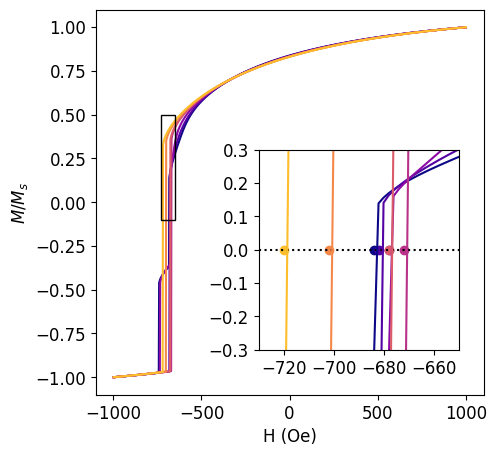

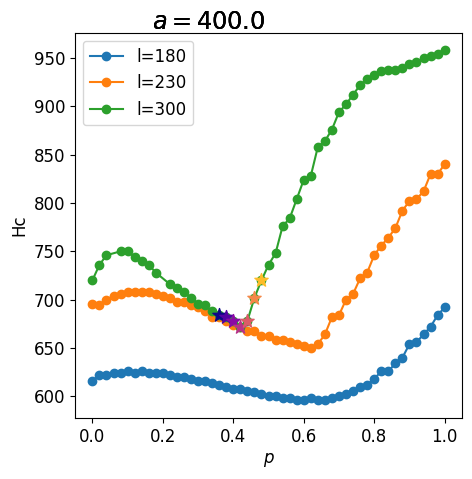

In [341]:
mpl.rcParams.update({'font.size': 12})

def plotAttr(attr,spacing,name="",keyPs=[],keyA=0,keyLength=0):
    fig,axs=plt.subplots()
    fig.set_size_inches(5,5)
    ax=axs
    ax.set_ylabel(name)
   
    for length in lengthVals:
        

        y=[]
        x=[]
        for pointiness in pointinessVals:
            runs = getRuns(spacing,pointiness,length)
            if len(runs)==0:continue
            run=runs[0]
            y.append(attr(run))
            x.append(pointiness)
            if pointiness in keyPs and spacing==keyA and length==keyLength:
                ax.scatter(x[-1],y[-1],marker="*",color=plt.cm.plasma(ps.index(pointiness)/len(ps)),zorder=10,s=100)
        ax.plot(x,y,"o-",label=f"l={round(length*1e9)}")
        ax.set_xlabel("$p$")
        ax.text(0.2,1.01,f"$a={spacing*1e9}$",transform=ax.transAxes,size="x-large")
        ax.legend()
    plt.savefig("test.png",bbox_inches="tight")
    plt.show()

#plotAttr(lambda run:run.attrs["Hc"],"Hc")

#plotAttr(lambda run:run.attrs["Br"],"Mr")

############################################################################
ps=[0.36,0.38,0.40,0.42,0.44,0.46,0.48]

#ps=[0.40,0.42,0.44,0.46,0.48]


####################################
spacing=400e-9
length=300e-9
fig,ax=plt.subplots()
fig.set_size_inches(5,5)
ax.set_xlabel("H (Oe)")
ax.set_ylabel("$M/M_s$")



left, bottom, width, height = [0.45, 0.2, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim(-730,-650)
ax2.set_ylim(-0.3,0.3)
ax2.axhline(0,ls=":",color="k")
ax.add_patch(mpl.patches.Rectangle((-730,-0.1),80,0.6,zorder=10,fill=False,ec="k"))
for i,pointiness in enumerate(ps):
    runs=getRuns(spacing,pointiness,length)
    if len(runs)==0:continue
    else: run=runs[0]

    ax.plot(run["H"],run["m"],label=f"$l={length*1e9}$",color=plt.cm.plasma(i/len(ps)))
    ax2.plot(run["H"],run["m"],label=f"$l={length*1e9}$",color=plt.cm.plasma(i/len(ps)))
    ax2.scatter(-run.attrs["Hc"],0,color=plt.cm.plasma(i/len(ps)))
plt.savefig(f"test2.png",bbox_inches="tight")
plt.show()



plotAttr(lambda run:run.attrs["Hc"],spacing,"Hc",ps,spacing,length)
#plotAttr(lambda run:run.attrs["Br"],"Mr")



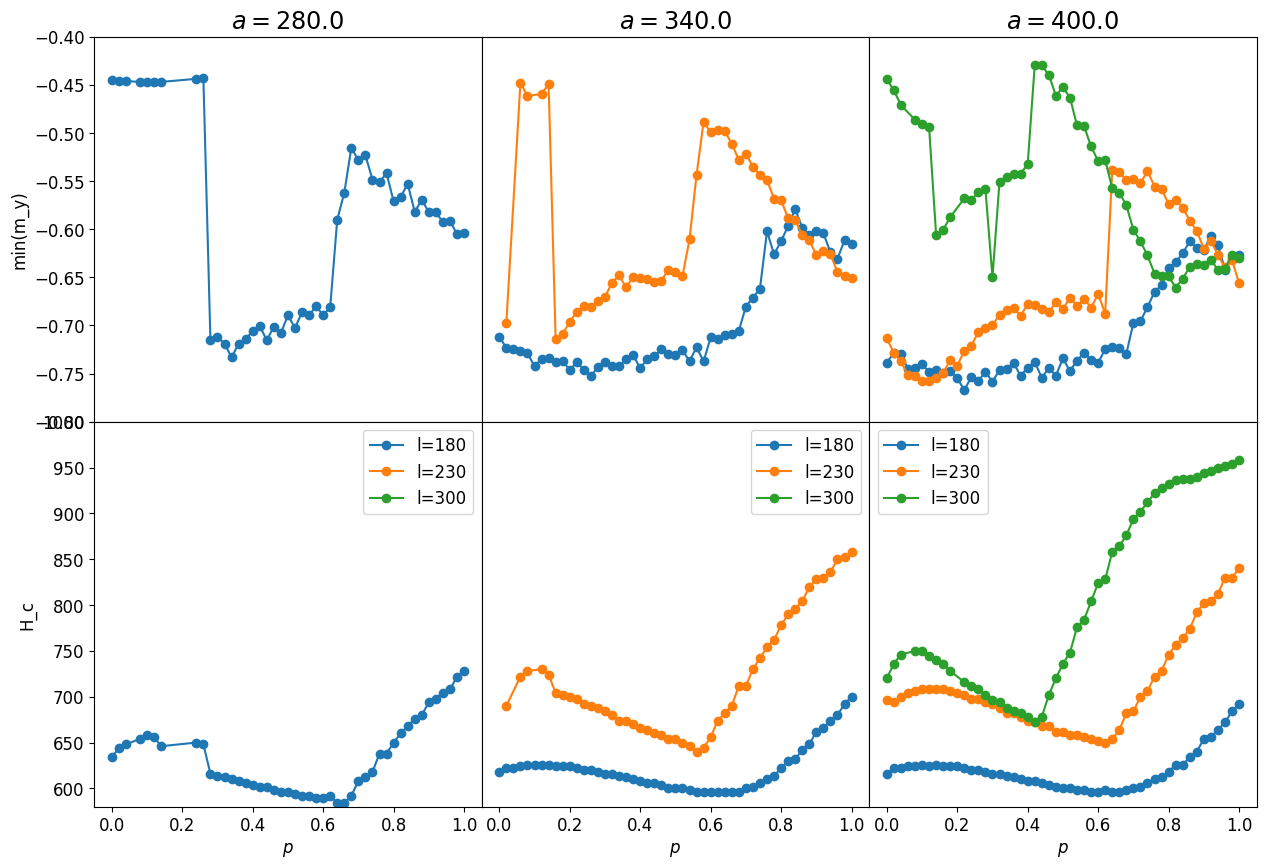

In [203]:
fig,axs=plt.subplots(2,3)
fig.set_size_inches(15,10)
plt.subplots_adjust(wspace=0, hspace=0)

axI=-1
axs[0][0].set_ylabel("min(m_y)")
axs[1][0].set_ylabel("H_c")

for spacing in spacingVals:
    axI+=1
    ax0=axs[0][axI]
    ax1=axs[1][axI]
    for length in lengthVals:
        

        y=[]
        y2=[]
        x=[]
        for pointiness in pointinessVals:
            runs = getRuns(spacing,pointiness,length)
            if len(runs)==0:continue
            run=runs[0]
            y.append(run.attrs["Hc"])
            y2.append(min(run["hIsland_my"]))
            x.append(pointiness)
        ax1.plot(x,y,"o-",label=f"l={round(length*1e9)}")
        ax1.set_xlabel("$p$")
        ax0.plot(x,y2,"o-")
        ax0.set_ylim(-0.8,-0.4)
        ax1.set_ylim(580,1000)
        ax1.legend()

    if axI!=0:
        ax0.set_yticks([])
        ax1.set_yticks([])
    #if axI==1:
    #    ax0.axvline(0.56,c="k",ls=":")
    #    ax1.axvline(0.56,c="k",ls=":")
    ax0.set_title(f"$a={spacing*1e9}$",size="x-large")
    #if axI==0: ax.legend()
plt.savefig("test.png",bbox_inches="tight")
plt.show()